# Performance Control (Equity Control)

#### Riportiamo il codice ottenuto:

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

def stop_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup stop
    Viene verificata il superamento del massimo (long) o minimo (short) sul level
    """
    service_dataframe = pd.DataFrame(index = dataframe.index)
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high

    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

def limit_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup limit
    Viene verificata il raggiungimento del minimo (long) o massimo (short) sul level
    """
    service_dataframe = pd.DataFrame()
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high
    
    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) & \
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

def marketposition_generator(enter_rules,exit_rules):
    """
    Funzione per calcolare il marketposition date due serie di enter_rules and exit_rules
    """
    service_dataframe = pd.DataFrame(index = enter_rules.index)
    service_dataframe['enter_rules'] = enter_rules
    service_dataframe['exit_rules'] = exit_rules
    
    status = 0
    mp = []
    for (i, j) in zip(enter_rules, exit_rules):
        if status == 0:
            if i == 1 and j != -1:
                status = 1
        else:
            if j == -1:
                status = 0
        mp.append(status)
        
    service_dataframe['mp_new'] = mp
    service_dataframe.mp_new = service_dataframe.mp_new.shift(1)
    service_dataframe.iloc[0,2] = 0
    service_dataframe.to_csv("marketposition_generator.csv")
    return service_dataframe.mp_new

def apply_trading_system(dataframe, bigpointvalue, tick, direction, order_type, 
                         enter_level, enter_rules, exit_rules):
    
    if ORDER_TYPE == "stop":
        enter_rules = stop_check(dataframe,enter_rules,enter_level,direction)
    if ORDER_TYPE == "limit":
        enter_rules = limit_check(dataframe,enter_rules,enter_level,direction)
        
    dataframe['enter_level'] = enter_level
    dataframe['enter_rules'] = enter_rules.apply(lambda x: 1 if x == True else 0)
    dataframe['exit_rules'] = exit_rules.apply(lambda x: -1 if x == True else 0)
    
    dataframe["mp"] = marketposition_generator(dataframe.enter_rules,dataframe.exit_rules)
 
    if ORDER_TYPE == "market":
        dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                             dataframe.open, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / dataframe.open, np.nan)
    if ORDER_TYPE == "stop":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)   
    if ORDER_TYPE == "limit":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)                                                      
        
    dataframe["entry_price"] = dataframe["entry_price"].fillna(method='ffill')
    dataframe["events_in"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(1) == 0), "entry", "")
    if INSTRUMENT == 1:
        dataframe["number_of_stocks"] = dataframe["number_of_stocks"].apply(lambda x: round(x,0))\
                                        .fillna(method='ffill')
        
    if direction == "long":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                                    (dataframe.open.shift(-1) - dataframe.entry_price)
                                                    * dataframe.number_of_stocks - 2 * COSTS, 
                                                    dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.open.shift(-1) - dataframe.entry_price) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
            
    if direction == "short":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                            (dataframe.entry_price - dataframe.open.shift(-1))\
                                            * dataframe.number_of_stocks - 2 * COSTS,
                                            dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.entry_price - dataframe.open.shift(-1)) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
        
    dataframe["open_operations"] = np.where(dataframe.mp == 1, dataframe.open_operations, 0)
    dataframe["events_out"] = np.where((dataframe.mp == 1) & (dataframe.exit_rules == -1), "exit", "")      
    dataframe["operations"] = np.where((dataframe.exit_rules == -1) & (dataframe.mp == 1), 
                                        dataframe.open_operations, np.nan)
    dataframe["closed_equity"] = dataframe.operations.fillna(0).cumsum()
    dataframe["open_equity"] = dataframe.closed_equity + \
                               dataframe.open_operations - dataframe.operations.fillna(0)
    dataframe.to_csv("trading_system_export.csv")
    return dataframe

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

def load_data_intraday(filename):
    """
    Funzione per il parsing di una serie intraday 
    con estensione txt esportata da Tradestation
    """
    data = pd.read_csv(filename, 
                       usecols=['Date','Time','Open','High','Low','Close','Up','Down'], 
                       parse_dates=[['Date', 'Time']], )
    data.columns = ["date_time","open","high","low","close","up","down"]
    data.set_index('date_time', inplace = True)
    data['volume'] = data['up'] + data['down']
    data.drop(['up','down'],axis=1,inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    data["hour"] = data.index.hour
    data["minute"] = data.index.minute
    return data

def load_data_daily(filename):
    """
    Funzione per il caricamento di uno storico daily
    Fonte dati: Tradestation .txt
    """
    data = pd.read_csv(filename, parse_dates = ["Date","Time"])
    data.columns = ["date","time","open","high","low","close","volume","oi"]
    data.set_index("date", inplace = True)
    data.drop(["time","oi"], axis=1, inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    return data
    
def crossover(array1, array2):
    return (array1 > array2) & (array1.shift(1) < array2.shift(1))

def crossunder(array1, array2):
    return (array1 < array2) & (array1.shift(1) > array2.shift(1))
        
def plot_equity(equity,color):
    """
    Funzione per stampare un'equity line
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(equity, color=color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def drawdown(equity):
    """
    Funzione che calcola il draw down data un'equity line
    """
    maxvalue = equity.expanding(0).max()
    drawdown = equity - maxvalue
    drawdown_series = pd.Series(drawdown, index = equity.index)
    return drawdown_series

def plot_drawdown(equity,color):
    """
    Funzione per graficare la curva di draw down
    """
    dd = drawdown(equity)
    plt.figure(figsize = (12, 6), dpi = 300)
    plt.plot(dd, color = color)
    plt.fill_between(dd.index, 0, dd, color = color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Draw Down')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def plot_double_equity(closed_equity,open_equity):
    """
    Funzione per stampare due equity sovrapposte
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(open_equity, color='red')
    plt.plot(closed_equity, color='green')
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Open & Closed Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def profit(equity):
    return round(equity[-1],2)

def profit1(operations):
    return round(operations.sum(),2)
    
def operation_number(operations):
    return operations.count()
    
def avg_trade(operations):
    return round(operations.mean(),2)
    
def max_draw_down(equity):
    dd = drawdown(equity)
    return round(dd.min(),2)
    
def avgdrawdown_nozero(equity):
    """
    calcola la media del draw down storico
    non considerando i valori nulli (nuovi massimi di equity line)
    """
    dd = drawdown(equity)
    return round(dd[dd < 0].mean(),2)

def avg_loss(operations):
    return round(operations[operations < 0].mean(),2)
    
def max_loss(operations):
    return round(operations.min(),2)
    
def max_loss_date(operations):
    return operations.idxmin()
    
def avg_gain(operations):
    return round(operations[operations > 0].mean(),2)
    
def max_gain(operations):
    return round(operations.max(),2)
    
def max_gain_date(operations):
    return operations.idxmax()
    
def gross_profit(operations):
    return round(operations[operations > 0].sum(),2)
    
def gross_loss(operations):
    return round(operations[operations <= 0].sum(),2)
    
def profit_factor(operations):
    a = gross_profit(operations)
    b = gross_loss(operations)
    if b != 0:
        return round(abs(a / b), 2)
    else:
        return round(abs(a / 0.00000001), 2)
        
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)
    
def reward_risk_ratio(operations):
    if operations[operations <= 0].mean() != 0:
        return round((operations[operations > 0].mean() / -operations[operations <= 0].mean()),2)
    else:
        return np.inf
        
def delay_between_peaks(equity):
    """
    Funzione per calcolare i ritardi istantanei in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else 0)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    #print(work_df.iloc[-20:,:])
    a = pd.Series(work_df['delay_elements'].groupby(work_df['cumsum']).cumsum())
    return a

def max_delay_between_peaks(equity):
    """
    Funzione per calcolare il più lungo ritardo in barre dall'ultimo massimo
    Input: equity line
    """
    a = delay_between_peaks(equity)
    return a.max()
    
def avg_delay_between_peaks(equity):
    """
    Funzione per calcolare il ritardo medio in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else np.nan)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    work_df.dropna(inplace = True)
    a = work_df['delay_elements'].groupby(work_df['cumsum']).sum()
    return round(a.mean(),2)
    
def plot_annual_histogram(operations):
    yearly = operations.resample('A').sum()
    colors = pd.Series()
    colors = yearly.apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(yearly)
    plt.subplots(figsize=(10, 7), dpi=200)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     yearly,
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Years')
    plt.ylabel('Profit - Loss')
    plt.title('Yearly Profit-Loss - by Gandalf Project R&D')
    plt.xticks(index, yearly.index.year, rotation=90)
    plt.grid(True)
    plt.show()
    return
    
def plot_monthly_bias_histogram(operations):
    monthly = pd.DataFrame(operations.fillna(0)).resample('M').sum()
    monthly['Month'] = monthly.index.month
    biasMonthly = []
    months = []

    for month in range(1, 13):
        months.append(month)
    for month in months:
        biasMonthly.append(monthly[(monthly['Month'] == month)].mean())

    biasMonthly = pd.DataFrame(biasMonthly)
    column = biasMonthly.columns[0]
    colors = pd.Series()
    colors = biasMonthly[column].apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(biasMonthly)
    plt.subplots(figsize=(14, 6), dpi=300)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     biasMonthly[column],
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Months')
    plt.ylabel('Average Profit - Loss')
    plt.title('Average Monthly Profit-Loss - by Gandalf Project R&D')
    months_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September",
                    "October", "November", "December"]
    plt.xticks(index, months_names, rotation=45)
    plt.grid(True)
    plt.show()
    return
    
def plot_equity_heatmap(operations,annotations):
    monthly = operations.resample('M').sum()
    toHeatMap = pd.DataFrame(monthly)
    toHeatMap["Year"] = toHeatMap.index.year
    toHeatMap["Month"] = toHeatMap.index.month
    Show = toHeatMap.groupby(by=['Year','Month']).sum().unstack()
    Show.columns = ["January","February","March","April","May","June",
                    "July","August","September","October","November","December"]
    plt.figure(figsize=(8,6),dpi=120)
    sns.heatmap(Show, cmap="RdYlGn", linecolor="white", linewidth=0.1, annot=annotations, 
                vmin=-max(monthly.min(),monthly.max()), vmax=monthly.max())
    return
    
def performance_report(trading_system,operations,closed_equity,open_equity):
    print("Performance Report - by Gandalf Project R&D")
    print("")
    print("Profit:                  ", profit(open_equity))
    print("Operations:              ", operation_number(operations))
    print("Average Trade:           ", avg_trade(operations))
    print("")
    print("Profit Factor:           ", profit_factor(operations))
    print("Gross Profit:            ", gross_profit(operations))
    print("Gross Loss:              ", gross_loss(operations))
    print("")
    print("Percent Winning Trades:  ", percent_win(operations))
    print("Percent Losing Trades:   ", round(100 - percent_win(operations),2))
    print("Reward Risk Ratio:       ", reward_risk_ratio(operations))
    print("")
    print("Max Gain:                ", max_gain(operations), " in date ", max_gain_date(operations))
    print("Average Gain:            ", avg_gain(operations))
    print("Max Loss:                ", max_loss(operations), " in date ", max_loss_date(operations))
    print("Average Loss:            ", avg_loss(operations))
    print("")
    print("Avg Open Draw Down:      ", avgdrawdown_nozero(open_equity))
    print("Max Open Draw Down:      ", max_draw_down(open_equity))
    print("")
    print("Avg Closed Draw Down:    ", avgdrawdown_nozero(trading_system.closed_equity))
    print("Max Closed Draw Down:    ", max_draw_down(trading_system.closed_equity))
    print("")
    print("Avg Delay Between Peaks: ", avg_delay_between_peaks(trading_system.open_equity))
    print("Max Delay Between Peaks: ", max_delay_between_peaks(trading_system.open_equity))
    print("")
    print("Calmar Ratio:            ", my_calmar_ratio(trading_system.open_equity))
    print("Calmar Ratio Yearly:     ", my_calmar_ratio_yearly(operations,trading_system.open_equity)[0])
    print("Sharpe Ratio:            ", my_sharpe_ratio(trading_system.open_equity))
    print("Sharpe Ratio Yearly:     ", my_sharpe_ratio_yearly(operations)[0])   
    print("Kestner Ratio:           ", my_kestner_ratio(operations))
    plot_equity(trading_system.open_equity,"green")
    plot_drawdown(trading_system.open_equity,"red")
    plot_annual_histogram(operations)
    plot_monthly_bias_histogram(operations)
    plot_equity_heatmap(operations,False)
    return

import math

def tick_correction_up(level,tick):
    if level != level:
        level = 0
    multiplier = math.ceil(level/tick)
    return multiplier * tick

def tick_correction_down(level,tick):
    if level != level:
        level = 0
    multiplier = math.floor(level/tick)
    return multiplier * tick

def my_calmar_ratio(equity):
    """
    Il rapporto tra il guadagno finale e il max draw down registrato
    """
    netprofit = equity[-1]
    mdd = max_draw_down(equity)
    if mdd != 0:
        return round(netprofit / -mdd, 2)
    else:
        return np.inf
    
def my_calmar_ratio_yearly(operations,equity):
    """
    Il rapporto medio su base annuale tra
    il guadagno ed il draw down
    """
    yearly_operations = operations.resample('A').sum()
    yearly_drawdown = drawdown(equity).resample('A').min()
    records = []
    
    for i in range(len(yearly_operations)):
        if yearly_drawdown[i] != 0:
            records.append(-yearly_operations[i] / yearly_drawdown[i])
        else:
            records.append(np.inf)
            
    records = pd.Series(records, index = yearly_operations.index)
    return round(records.mean(),2), records

def my_sharpe_ratio(equity):
    """
    Il rapporto tra il guadagno totale 
    e la deviazione standard dell'equity line
    """
    netprofit = equity[-1]
    std = equity.std()
    if std != 0:
        return round(netprofit / std,2)
    else:
        return np.inf

def my_sharpe_ratio_yearly(operations):
    """
    Il rapporto medio su base annuale tra
    il guadagno e la deviazione standard
    """
    yearly_operations = operations.resample('A').sum()
    yearly_std = operations.resample('A').std()
    records = []
    
    for i in range(len(yearly_operations)):
        if yearly_std[i] != 0:
            records.append(yearly_operations[i] / yearly_std[i])
        else:
            records.append(np.inf)
            
    records = pd.Series(records, index = yearly_operations.index)
    
    return round(records.mean(),2), records

def my_kestner_ratio(operations):
    """
    Kestner Ratio versione 2003
    Una volta calcolata l'equity line dei contributi mensili delle operazioni aggregate
    calcoliamo la retta di regressione che meglio approssima lo sciame di punti 
    e riportiamo il rapporto tra la pendenza di tale retta e l'errore standard
    tra ogni punto e la retta medesima
    """
    import numpy as np
    import matplotlib.pyplot as plt 
    from scipy import stats
    
    monthly_operations = operations.resample('M').sum().fillna(0)
    monthly_equity = monthly_operations.cumsum()
    index = np.array(np.arange(1,monthly_operations.count() + 1))
    
    x = index
    y = monthly_equity
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    if std_err != 0 and len(index) > 0:
        return round(gradient / (std_err * len(index)),4)
    else:
        return np.inf

### A questo punto carichiamo una lista di trade:

In [2]:
data = load_data_intraday("@PL_15min_Exchange.txt")
dataset = data.copy()
dataset["hhv92"] = dataset.high.rolling(92).max()
dataset["llv92"] = dataset.low.rolling(92).min()
dataset["daily_high1"] = dataset.high.resample("D").max().shift(1)
dataset["daily_high1"] = dataset["daily_high1"].fillna(method = 'ffill')
dataset["daily_low1"] = dataset.low.resample("D").min().shift(1)
dataset["daily_low1"] = dataset["daily_low1"].fillna(method = 'ffill')
dataset["daily_open1"] = dataset.open.resample("D").first().shift(1)
dataset["daily_open1"] = dataset["daily_open1"].fillna(method = 'ffill')
dataset["daily_close1"] = dataset.close.resample("D").last().shift(1)
dataset["daily_close1"] = dataset["daily_close1"].fillna(method = 'ffill')
dataset["range1"] = dataset["daily_high1"] - dataset["daily_low1"]
dataset["ORB_UP"] = np.where(dataset.day != dataset.day.shift(1),dataset.open + 0.5 * dataset.range1,np.NaN)
dataset["ORB_UP"] = dataset["ORB_UP"].fillna(method = 'ffill')
dataset["ORB_DOWN"] = np.where(dataset.day != dataset.day.shift(1),dataset.open - 0.5 * dataset.range1,np.NaN)
dataset["ORB_DOWN"] = dataset["ORB_DOWN"].fillna(method = 'ffill')
blastoff = abs(dataset.daily_open1 - dataset.daily_close1) < 0.4 * (dataset.daily_high1 - dataset.daily_low1)
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 50
TICK = 0.10
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"

enter_rules = blastoff
enter_level = dataset.ORB_UP

exit_rules = dataset.day != dataset.day.shift(1)

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()
    
operations.head(10)

date_time
2007-01-10 00:45:00    -55.0
2007-01-11 01:15:00   -405.0
2007-01-12 00:00:00   -315.0
2007-01-14 18:15:00    300.0
2007-01-18 01:15:00    -95.0
2007-01-19 00:30:00   -500.0
2007-01-21 21:30:00      0.0
2007-01-26 00:45:00   -250.0
2007-01-31 01:15:00   -270.0
2007-02-01 04:45:00    425.0
Name: operations, dtype: float64

In [3]:
operations.count()

750

Performance Report - by Gandalf Project R&D

Profit:                   55735.0
Operations:               750
Average Trade:            74.31

Profit Factor:            1.44
Gross Profit:             182500.0
Gross Loss:               -126765.0

Percent Winning Trades:   53.87
Percent Losing Trades:    46.13
Reward Risk Ratio:        1.23

Max Gain:                 3420.0  in date  2008-09-23 00:00:00
Average Gain:             451.73
Max Loss:                 -3700.0  in date  2008-10-31 00:00:00
Average Loss:             -369.58

Avg Open Draw Down:       -3032.41
Max Open Draw Down:       -9910.0

Avg Closed Draw Down:     -3292.25
Max Closed Draw Down:     -9440.0

Avg Delay Between Peaks:  784.65
Max Delay Between Peaks:  136912

Calmar Ratio:             5.62
Calmar Ratio Yearly:      1.76
Sharpe Ratio:             2.8
Sharpe Ratio Yearly:      5.59
Kestner Ratio:            0.1226


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


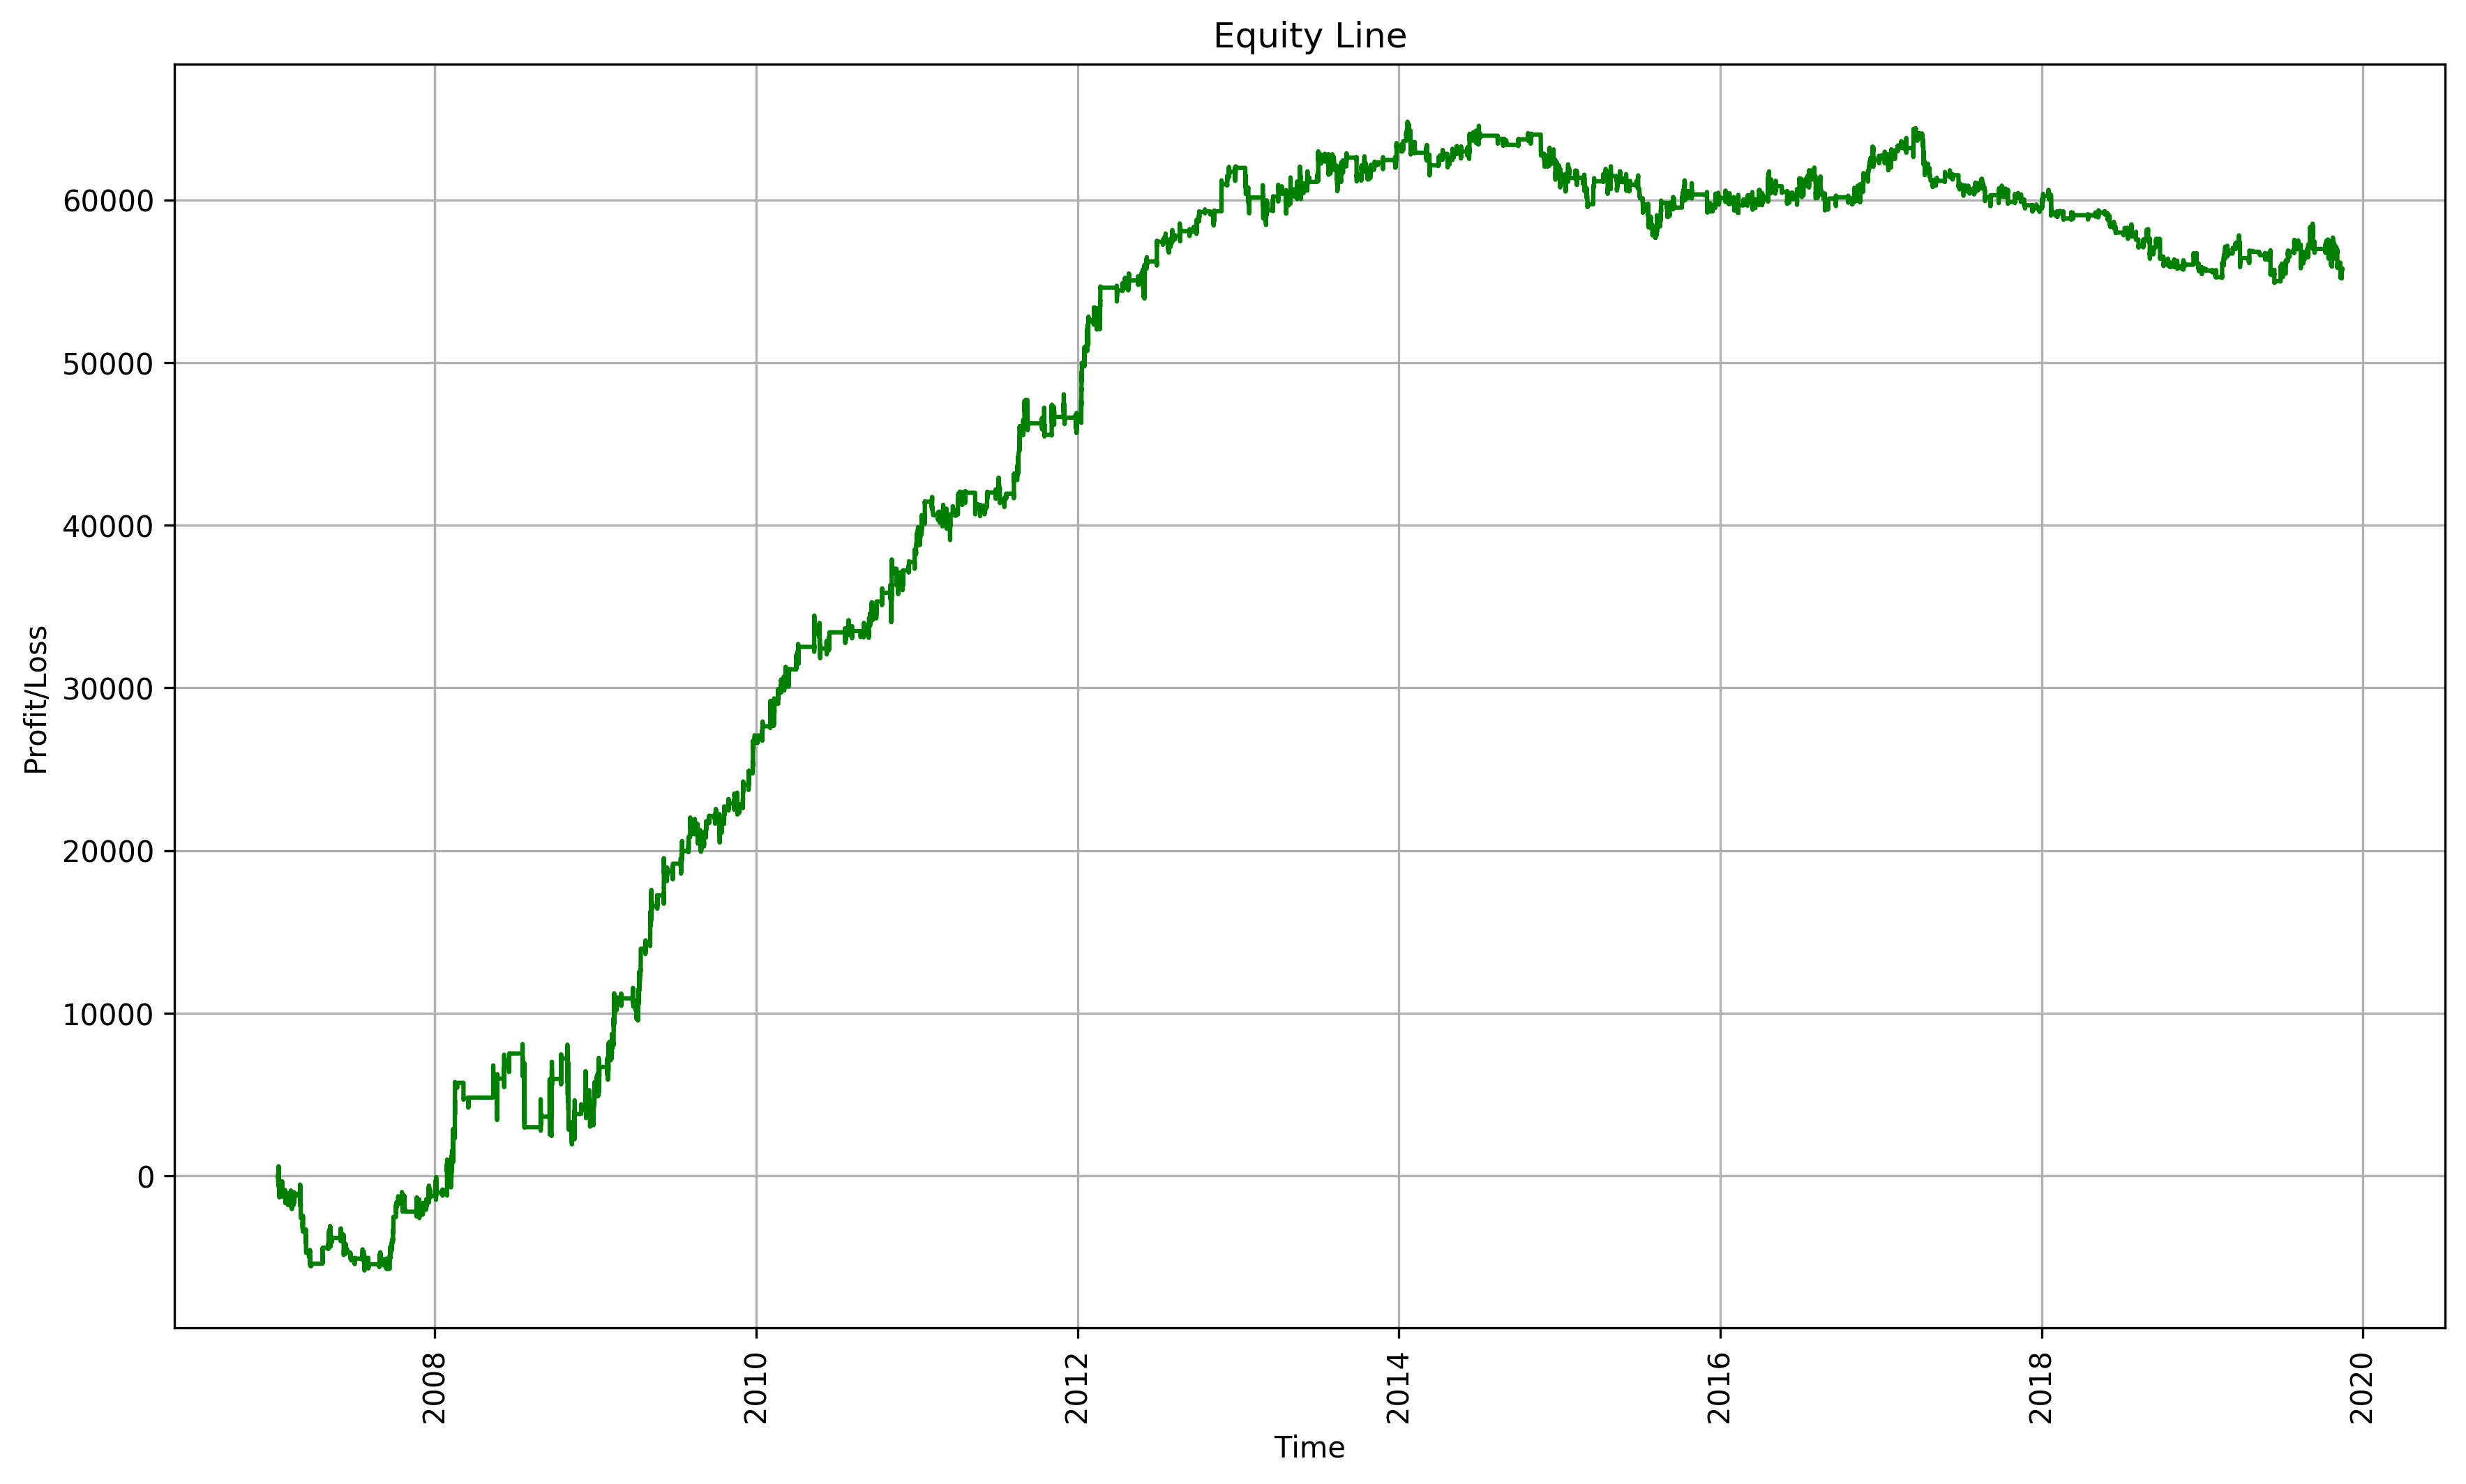

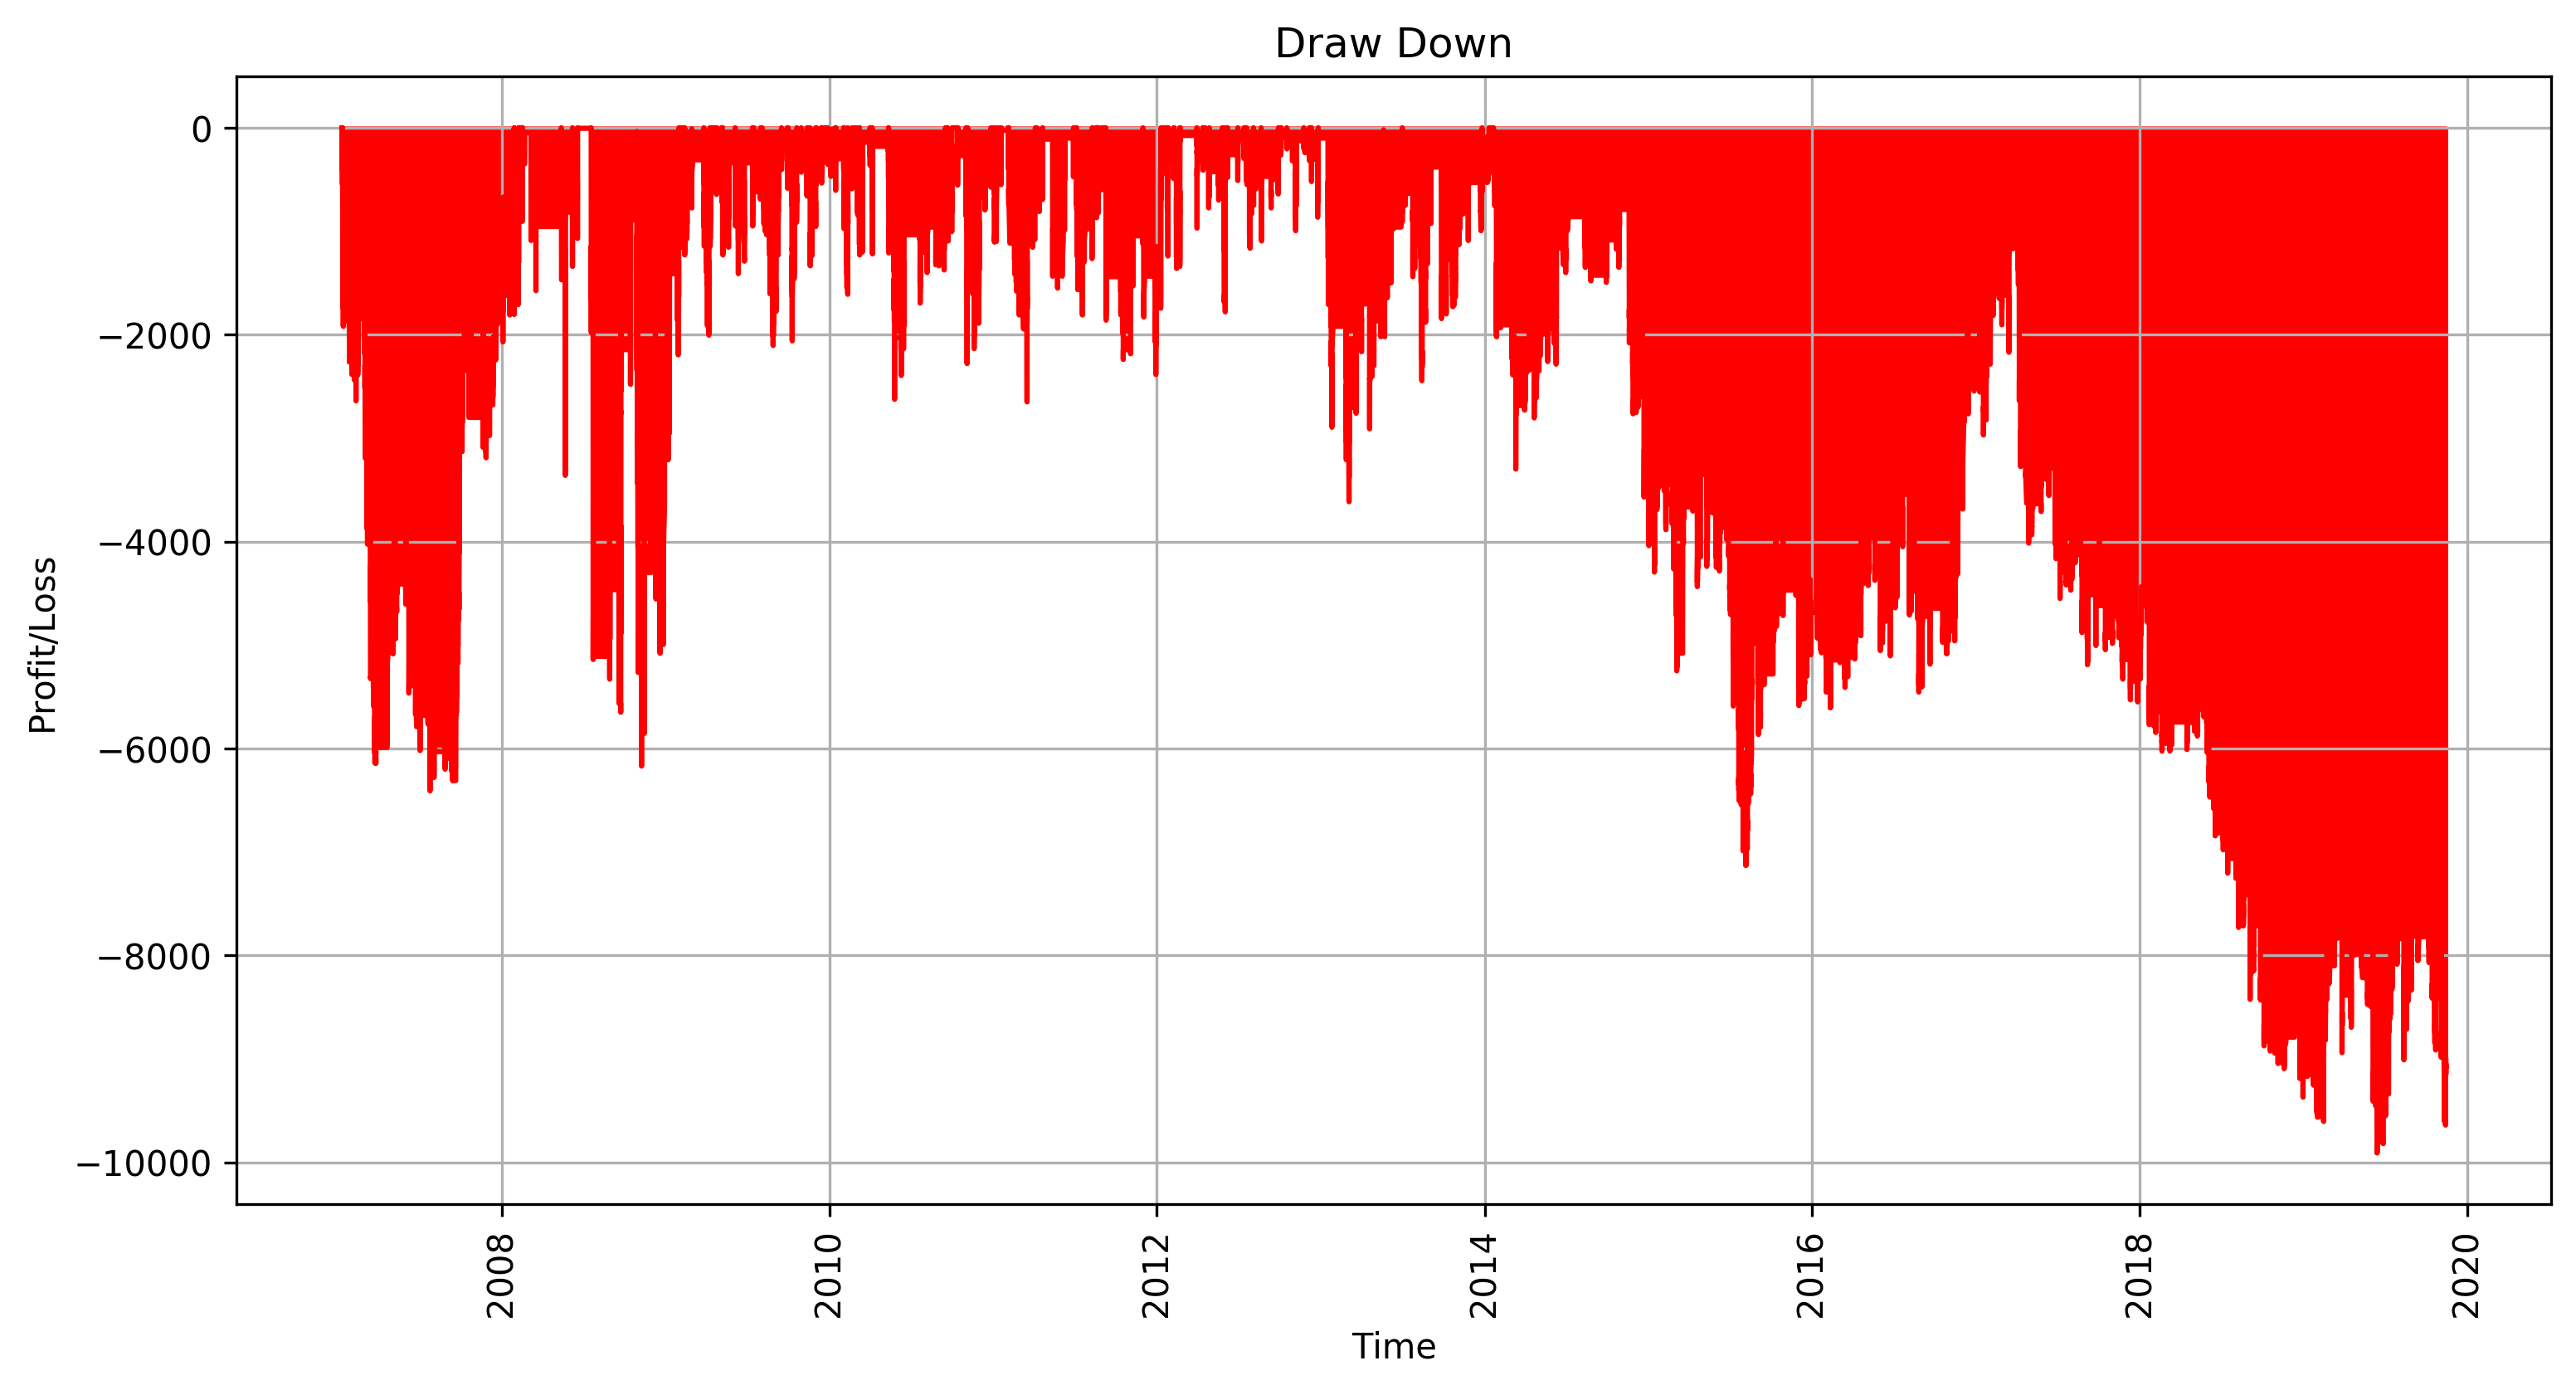

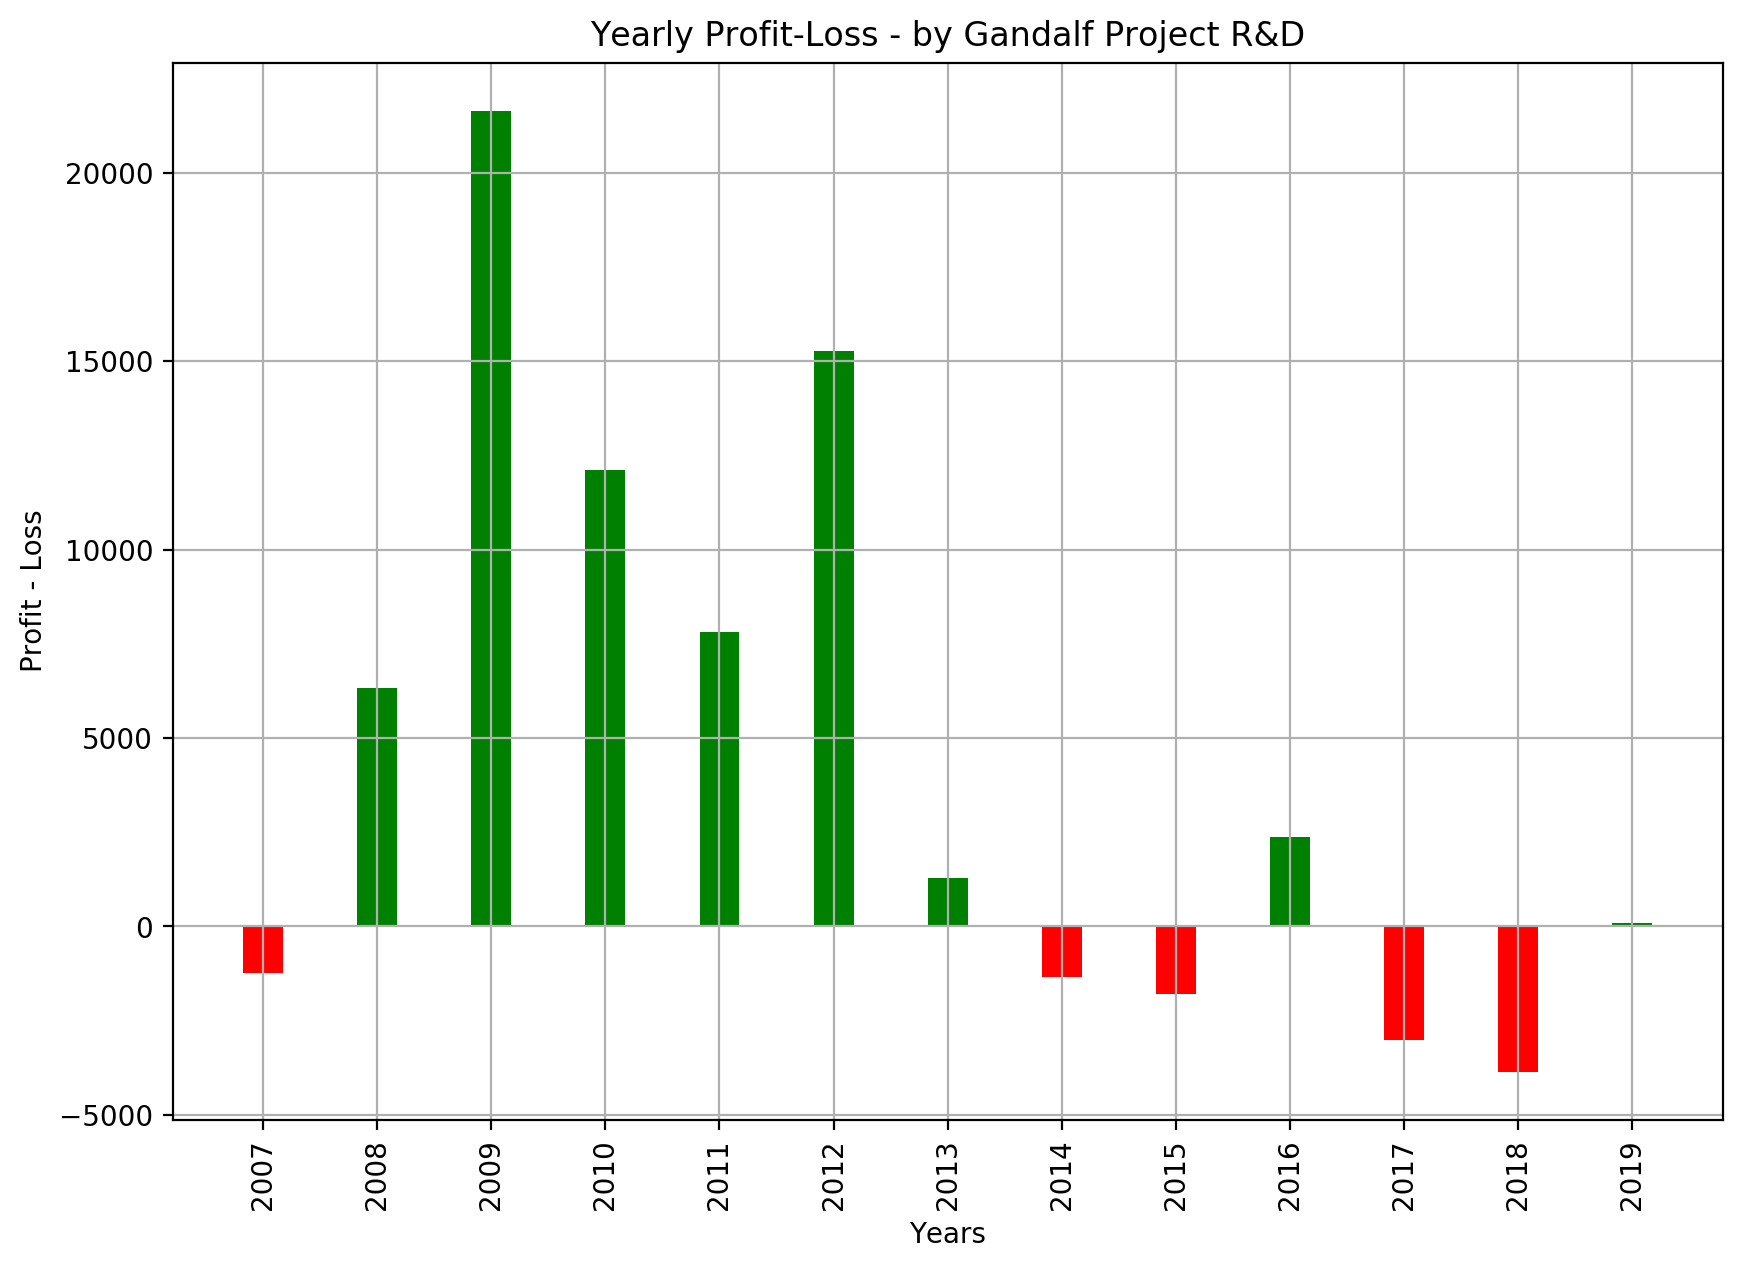

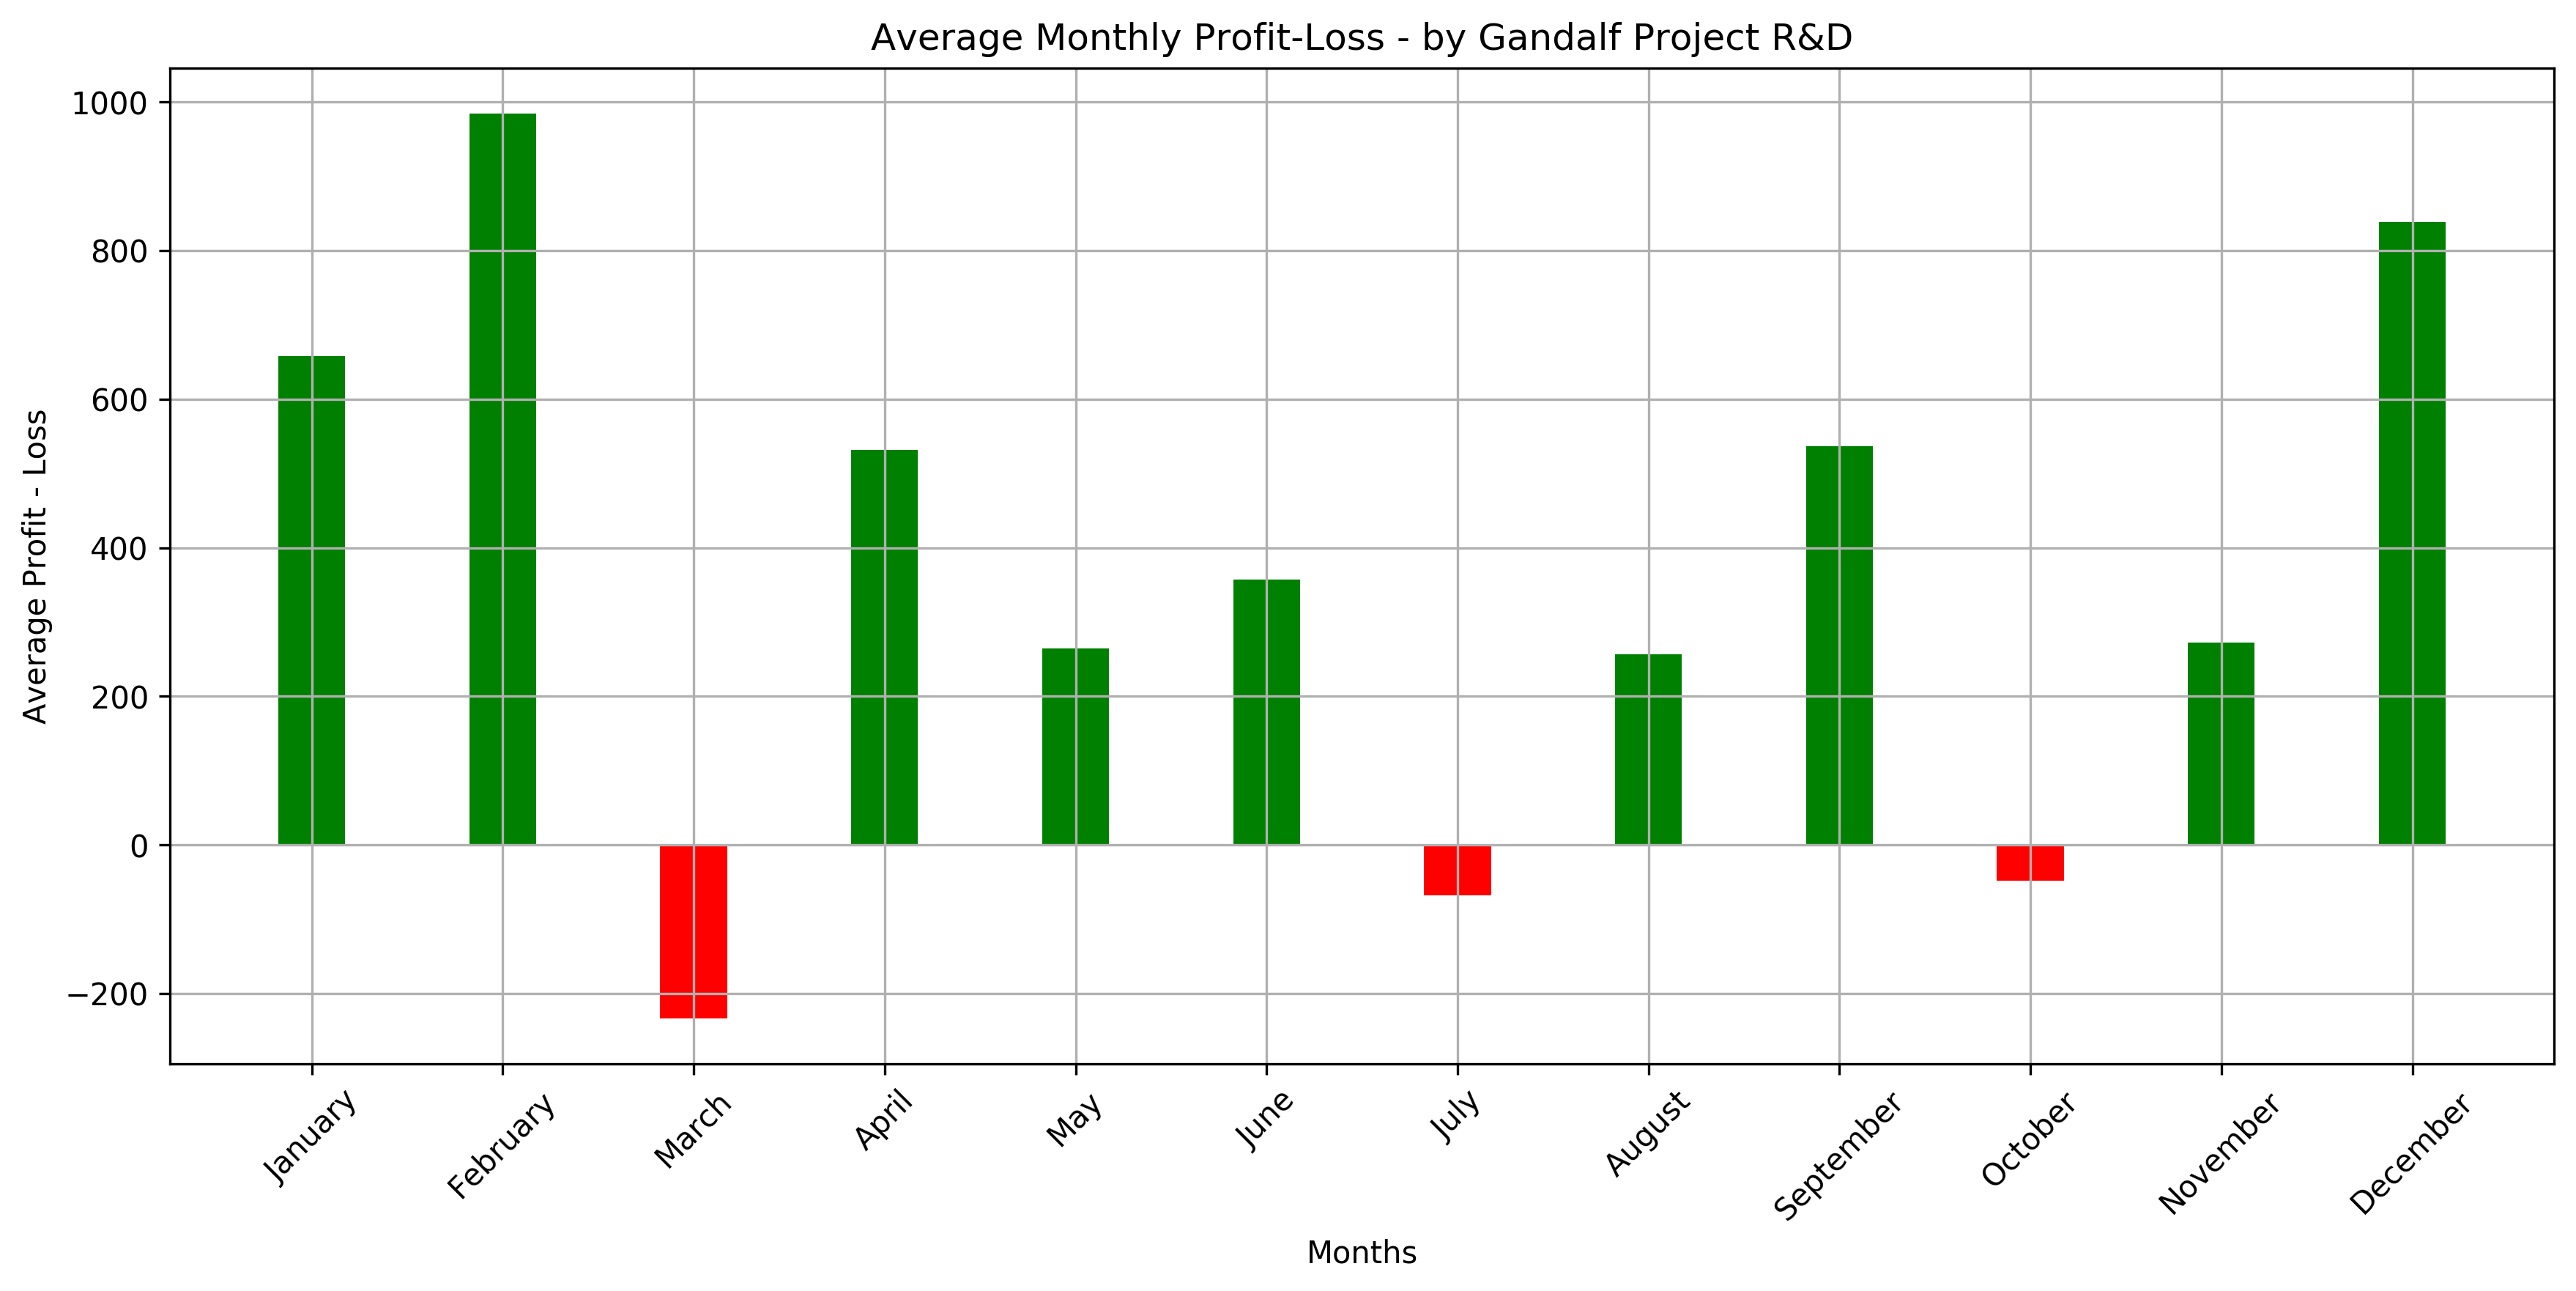

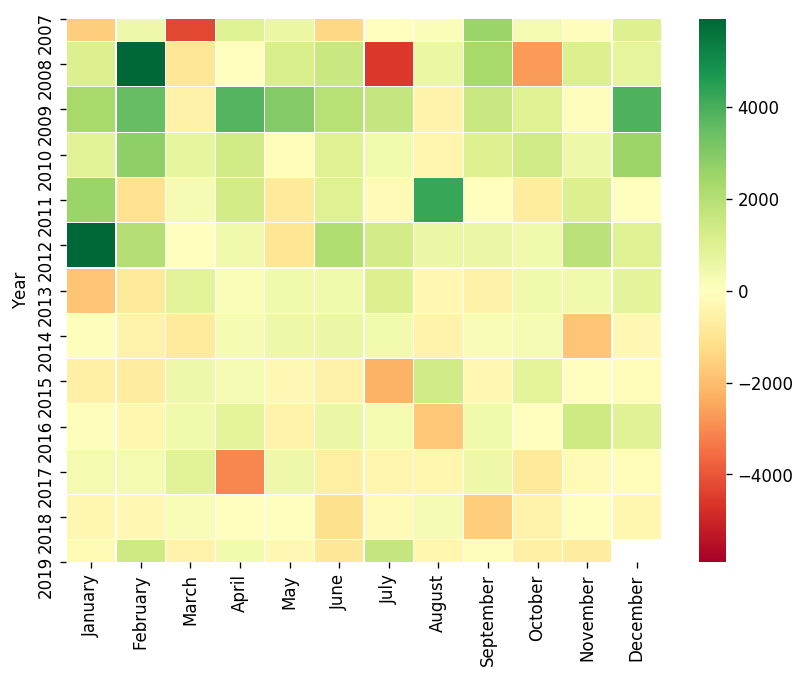

In [4]:
if operations.count() > 0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")

### Window Profit Factor

In [113]:
PERIOD = 20
THRESHOLD = 1

df = pd.DataFrame(operations)
df.columns = ["original"]
df["positive"] = np.where(df.original > 0,df.original,0)
df["negative"] = np.where(df.original < 0,df.original,0)
df["window_gross_profit"] = df.positive.rolling(PERIOD).sum()
df["window_gross_loss"] = df.negative.rolling(PERIOD).sum()
df["window_profit_factor"] = df.window_gross_profit / -df.window_gross_loss
df["controlled"] = np.where(df.window_profit_factor.shift(1) > THRESHOLD, df.original, 0)
df["equity_original"] = df.original.cumsum()
df["equity_controlled"] = df.controlled.cumsum()
df.head(10)

,original,positive,negative,window_gross_profit,window_gross_loss,window_profit_factor,controlled,equity_original,equity_controlled
date_time,,,,,,,,,
2007-01-10 00:45:00,-55.0,0.0,-55.0,NaN,NaN,NaN,0.0,-55.0,0.0
2007-01-11 01:15:00,-405.0,0.0,-405.0,NaN,NaN,NaN,0.0,-460.0,0.0
2007-01-12 00:00:00,-315.0,0.0,-315.0,NaN,NaN,NaN,0.0,-775.0,0.0
2007-01-14 18:15:00,300.0,300.0,0.0,NaN,NaN,NaN,0.0,-475.0,0.0
2007-01-18 01:15:00,-95.0,0.0,-95.0,NaN,NaN,NaN,0.0,-570.0,0.0
2007-01-19 00:30:00,-500.0,0.0,-500.0,NaN,NaN,NaN,0.0,-1070.0,0.0
2007-01-21 21:30:00,0.0,0.0,0.0,NaN,NaN,NaN,0.0,-1070.0,0.0
2007-01-26 00:45:00,-250.0,0.0,-250.0,NaN,NaN,NaN,0.0,-1320.0,0.0
2007-01-31 01:15:00,-270.0,0.0,-270.0,NaN,NaN,NaN,0.0,-1590.0,0.0


In [119]:
def equity_control_wpf(operations,period,threshold):
    df = pd.DataFrame(operations)
    df.columns = ["original"]
    df["positive"] = np.where(df.original > 0,df.original,0)
    df["negative"] = np.where(df.original < 0,df.original,0)
    df["window_gross_profit"] = df.positive.rolling(period).sum()
    df["window_gross_loss"] = df.negative.rolling(period).sum()
    df["window_profit_factor"] = df.window_gross_profit / -df.window_gross_loss
    df["controlled"] = np.where(df.window_profit_factor.shift(1) > threshold, df.original, 0)
    df["equity_original"] = df.original.cumsum()
    df["equity_controlled"] = df.controlled.cumsum()
    return df

PERIOD = 20
THRESHOLD = 1.2

df = equity_control_wpf(operations,PERIOD,THRESHOLD)
df.head(10)

,original,positive,negative,window_gross_profit,window_gross_loss,window_profit_factor,controlled,equity_original,equity_controlled
date_time,,,,,,,,,
2007-01-10 00:45:00,-55.0,0.0,-55.0,NaN,NaN,NaN,0.0,-55.0,0.0
2007-01-11 01:15:00,-405.0,0.0,-405.0,NaN,NaN,NaN,0.0,-460.0,0.0
2007-01-12 00:00:00,-315.0,0.0,-315.0,NaN,NaN,NaN,0.0,-775.0,0.0
2007-01-14 18:15:00,300.0,300.0,0.0,NaN,NaN,NaN,0.0,-475.0,0.0
2007-01-18 01:15:00,-95.0,0.0,-95.0,NaN,NaN,NaN,0.0,-570.0,0.0
2007-01-19 00:30:00,-500.0,0.0,-500.0,NaN,NaN,NaN,0.0,-1070.0,0.0
2007-01-21 21:30:00,0.0,0.0,0.0,NaN,NaN,NaN,0.0,-1070.0,0.0
2007-01-26 00:45:00,-250.0,0.0,-250.0,NaN,NaN,NaN,0.0,-1320.0,0.0
2007-01-31 01:15:00,-270.0,0.0,-270.0,NaN,NaN,NaN,0.0,-1590.0,0.0


### Window Profit

In [5]:
def equity_control_wp(operations,period,threshold):
    df = pd.DataFrame(operations)
    df.columns = ["original"]
    df["window_profit"] = df.original.rolling(period).sum()
    df["controlled"] = np.where(df.window_profit.shift(1) > threshold, df.original, 0)
    df["equity_original"] = df.original.cumsum()
    df["equity_controlled"] = df.controlled.cumsum()
    return df

PERIOD = 10
THRESHOLD = 500

df = equity_control_wp(operations,PERIOD,THRESHOLD)
df.tail(13)

,original,window_profit,controlled,equity_original,equity_controlled
date_time,,,,,
2019-10-09 00:00:00,275.0,55.0,0.0,57260.0,53470.0
2019-10-11 00:00:00,95.0,850.0,0.0,57355.0,53470.0
2019-10-15 00:00:00,-120.0,690.0,-120.0,57235.0,53350.0
2019-10-16 00:00:00,-755.0,-150.0,-755.0,56480.0,52595.0
2019-10-20 18:15:00,25.0,-415.0,0.0,56505.0,52595.0
2019-10-22 00:00:00,-375.0,-1020.0,0.0,56130.0,52595.0
2019-10-24 00:00:00,1345.0,-810.0,0.0,57475.0,52595.0
2019-10-27 18:15:00,-375.0,-50.0,0.0,57100.0,52595.0
2019-10-29 00:00:00,-685.0,-720.0,0.0,56415.0,52595.0


### Window Average Trade

In [227]:
def equity_control_wat(operations,period,threshold):
    df = pd.DataFrame(operations)
    df.columns = ["original"]
    df["window_average_trade"] = df.original.rolling(period).mean()
    df["controlled"] = np.where(df.window_average_trade.shift(1) > threshold, df.original, 0)
    df["equity_original"] = df.original.cumsum()
    df["equity_controlled"] = df.controlled.cumsum()
    return df

PERIOD = 10
THRESHOLD = 100

df = equity_control_wat(operations,PERIOD,THRESHOLD)
df.tail(13)

,original,window_average_trade,controlled,equity_original,equity_controlled
date_time,,,,,
2019-10-09 00:00:00,275.0,5.5,0.0,57260.0,42580.0
2019-10-11 00:00:00,95.0,85.0,0.0,57355.0,42580.0
2019-10-15 00:00:00,-120.0,69.0,0.0,57235.0,42580.0
2019-10-16 00:00:00,-755.0,-15.0,0.0,56480.0,42580.0
2019-10-20 18:15:00,25.0,-41.5,0.0,56505.0,42580.0
2019-10-22 00:00:00,-375.0,-102.0,0.0,56130.0,42580.0
2019-10-24 00:00:00,1345.0,-81.0,0.0,57475.0,42580.0
2019-10-27 18:15:00,-375.0,-5.0,0.0,57100.0,42580.0
2019-10-29 00:00:00,-685.0,-72.0,0.0,56415.0,42580.0


In [6]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__) # necessaria versione >= 1.9.0

import cufflinks as cf

# Per utilizzo con Notebooks
init_notebook_mode(connected=True)

# Per utilizzo offline
cf.go_offline()

3.10.0


In [7]:
service = pd.DataFrame({"Original": df.equity_original,
                        "Controlled": df.equity_controlled})

service.iplot(kind = "line", title="Original vs Controlled Equities", colors = ["green","red"])

In [8]:
service2 = pd.DataFrame({"Original": drawdown(df.equity_original),
                        "Controlled": drawdown(df.equity_controlled)})

service2.iplot(kind = "line", title="Original vs Controlled Draw Downs", colors = ["green","red"])

In [10]:
signal = pd.DataFrame({'Control Signal': df.window_profit,
                       'Threshold': THRESHOLD})
signal.iplot(kind='line', title="Control Signal - by Gandalf Project R&D", colors=["red","black"])

In [11]:
df.controlled.fillna(0).iplot(kind='bar', color="red", title="Controlled Operations - by Gandalf Project R&D")

In [12]:
profit_original = round(operations.sum(),2)
nop_original = operations.count()
at_original = avg_trade(operations)
pf_original = profit_factor(operations)
pw_original = percent_win(operations)
rrr_original = reward_risk_ratio(operations)
add_original = avgdrawdown_nozero(operations)
mdd_original = max_draw_down(operations)

controlled_operations = df.controlled[df.controlled != 0]

profit_controlled = round(controlled_operations.sum(),2)
nop_controlled = controlled_operations.count()
at_controlled = avg_trade(controlled_operations)
pf_controlled = profit_factor(controlled_operations)
pw_controlled = percent_win(controlled_operations)
rrr_controlled = reward_risk_ratio(controlled_operations)
add_controlled = avgdrawdown_nozero(controlled_operations)
mdd_controlled = max_draw_down(controlled_operations)

print("BENCHMARK ORIGINAL - CONTROLLED:")
print("")
print("Number of Operations ->  Original:", nop_original, " Controlled:", nop_controlled, 
      "equivalent to", round(nop_controlled/nop_original*100,2), "%")
print("Profit               ->  Original:", profit_original, " Controlled:", profit_controlled,
      "equivalent to", round(profit_controlled/profit_original*100,2), "%")
print("Profit Factor        ->  Original:", pf_original, " Controlled:", pf_controlled,
      "equivalent to", round(pf_controlled/pf_original*100,2), "%")
print("Average Trade        ->  Original:", at_original, " Controlled:", at_controlled,
      "equivalent to", round(at_controlled/at_original*100,2), "%")
print("Percent Win          ->  Original:", pw_original, " Controlled:", pw_controlled,
      "equivalent to", round(pw_controlled/pw_original*100,2), "%")
print("Reward Risk Ratio    ->  Original:", rrr_original, " Controlled:", rrr_controlled,
      "equivalent to", round(rrr_controlled/rrr_original*100,2), "%")
print("Max Draw Down        ->  Original:", mdd_original, " Controlled:", mdd_controlled,
      "equivalent to", round(mdd_controlled/mdd_original*100,2), "%")
print("Average Draw Down    ->  Original:", add_original, " Controlled:", add_controlled,
      "equivalent to", round(add_controlled/add_original*100,2), "%")

BENCHMARK ORIGINAL - CONTROLLED:

Number of Operations ->  Original: 750  Controlled: 361 equivalent to 48.13 %
Profit               ->  Original: 55735.0  Controlled: 52595.0 equivalent to 94.37 %
Profit Factor        ->  Original: 1.44  Controlled: 1.87 equivalent to 129.86 %
Average Trade        ->  Original: 74.31  Controlled: 145.69 equivalent to 196.06 %
Percent Win          ->  Original: 53.87  Controlled: 58.73 equivalent to 109.02 %
Reward Risk Ratio    ->  Original: 1.23  Controlled: 1.31 equivalent to 106.5 %
Max Draw Down        ->  Original: -7120.0  Controlled: -6050.0 equivalent to 84.97 %
Average Draw Down    ->  Original: -3070.66  Controlled: -2429.94 equivalent to 79.13 %
